# TP53 benchmarking with JAPANESE BIOBANK CH DATA

#### Data from: Saiki et al 2021, Nat Med, Combined landscape of single-nucleotide variants and copy number alterations in clonal hematopoiesis https://www.nature.com/articles/s41591-021-01411-9

#### TP53 experimental assay from Kotler E, Shani O, Goldfeld G, Lotan-Pompan M, Tarcic O, Gershoni A, et al. A systematic p53 mutation library links differential functional impact to cancer mutation pattern and evolutionary conservation. Mol Cell 2018;71:178–90.e8.

### 1. Get and arrange data
### 2. Create positive set
### 3. Create negative set
### 4. Evaluation BoostDM vs Experimental assay

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
import copy
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 30)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from matplotlib import rcParams

In [2]:
TP53_Kotler = pd.read_csv('../../../Paper_data/Experimental_data/TP53/bench_TP53_Kotler.csv', sep='\t')
# Remove cases with two mutations
TP53_Kotler = TP53_Kotler[TP53_Kotler['Sec_mut_position'].isna()]
# Remove indels
remove = ['Ins', 'Del', 'IARC.InDel.GeneVars', 'DelAA', 'Del2AA',
         'Sub2bp', 'IARC.InDel.SomatMuts', 'wtp53_DBDA_seq', 'wtp53_DBDB_seq',
         'wtp53_DBDC_seq', 'wtp53_DBDD_seq', 'IARC.InDel.GermLine']
TP53_Kotler = TP53_Kotler[~TP53_Kotler['Mut_type'].isin(remove)]
TP53_Kotler['aachange'] = TP53_Kotler['AA_change'].str[0]+TP53_Kotler['Codon_num'].astype(str).str[:-2]+TP53_Kotler['AA_change'].str[-1]
TP53_Kotler

,Number,Var_seq,Identifier,SubLib,Backbone,Mut_type,Position,Seq_change,Codon_num,AA_change,Sec_mut_position,Sec_seq_change,Sec_codon_num,Sec_AA_change,MutID,IARC_Desc,Silent,RFS_H1299,aachange
0,1,AAATACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100001,DBDA,wt,AASub,304,ACC>AAA,102.0,T>K,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.224744,T102K
1,2,AGATACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100002,DBDA,wt,AASub,304,ACC>AGA,102.0,T>R,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.973493,T102R
2,3,ATGTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100003,DBDA,wt,AASub,304,ACC>ATG,102.0,T>M,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-3.400709,T102M
3,4,CACTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100004,DBDA,wt,AASub,304,ACC>CAC,102.0,T>H,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.277664,T102H
4,5,CTCTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTG...,100005,DBDA,wt,AASub,304,ACC>CTC,102.0,T>L,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.486801,T102L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9506,9821,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403439,DBDD,wt,Sub,875,A>C,292.0,K>T,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-1.786279,K292T
9507,9822,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403440,DBDD,wt,Sub,875,A>G,292.0,K>R,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-2.140749,K292R
9508,9823,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403441,DBDD,wt,Sub,875,A>T,292.0,K>I,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-1.771565,K292I
9512,9827,ATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCA...,403445,DBDD,wt,Sub,876,A>C,292.0,K>N,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,-1.443976,K292N


## 1. Get and arrange data

In [3]:
### Open Saiki et al. Mutations
japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')
japan_mutations = japan_ch[japan_ch['Start'].notna()]
japan_mutations = japan_mutations[japan_mutations['Gene.refGene']=='TP53']
print(len(japan_mutations))
japan_mutations.columns

148


/tmp/jobs/jramis/9874679/ipykernel_4386/3267725831.py:2: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,47,52,53,56,57,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')


Index(['id', 'sex', 'age', 'Chr', 'Start', 'End', 'Ref', 'Alt', 'Func.refGene',
       'Gene.refGene', 'GeneDetail.refGene', 'ExonicFunc.refGene',
       'Merge_Func', 'AAChange.refGene', 'cytoBand', 'genomicSuperDups',
       'esp6500siv2_all', 'X1000g2010nov_all', 'X1000g2014oct_all',
       'X1000g2014oct_afr', 'X1000g2014oct_eas', 'X1000g2014oct_eur', 'snp131',
       'snp138', 'snp131NonFlagged', 'snp138NonFlagged', 'cosmic68wgs',
       'cosmic70', 'clinvar_20150629', 'SIFT_score', 'SIFT_pred',
       'Polyphen2_HDIV_score', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_score',
       'Polyphen2_HVAR_pred', 'LRT_score', 'LRT_pred', 'MutationTaster_score',
       'MutationTaster_pred', 'MutationAssessor_score',
       'MutationAssessor_pred', 'FATHMM_score', 'FATHMM_pred',
       'RadialSVM_score', 'RadialSVM_pred', 'LR_score', 'LR_pred',
       'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP.._RS',
       'phyloP46way_placental', 'phyloP100way_vertebrate',
       'SiPhy_29way_logOdds', '

In [4]:
### Select only SNVs

japan_mutations_sel = japan_mutations[japan_mutations['Ref'].isin(['A','C','T','G']) &
                              japan_mutations['Alt'].isin(['A','C','T','G'])].reset_index(drop=True)
print(japan_mutations_sel['ExonicFunc.refGene'].value_counts())

nonsynonymous SNV    124
stopgain               7
synonymous SNV         3
Name: ExonicFunc.refGene, dtype: int64


In [5]:
### Arrange data

# Change chromosome nomenclature
japan_mutations_sel['Chr'] = japan_mutations_sel['Chr'].astype(int)

In [6]:
### Get position hg38

from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')

def hg38_conv (x):
    try:
        hg38 = lo.convert_coordinate('chr' + str(x['Chr']), x['Start'])[0][1]
        return hg38
    except:
        print('WARNING: not transformed')
        print(x['Chromosome'], x['Start_Position'])

# Apply to 12 genes selection
japan_mutations_sel['pos_hg38'] = japan_mutations_sel.apply(lambda x: hg38_conv(x), axis=1)

In [7]:
### Substitute U2AF1;U2AF1L5  by U2AF1

japan_mutations_sel['Gene.refGene'] = japan_mutations_sel['Gene.refGene'].apply(lambda x: x.split(';')[0])
japan_mutations_sel['Gene.refGene'].value_counts()

TP53    139
Name: Gene.refGene, dtype: int64

In [8]:
### Select unique mutations
japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt']].drop_duplicates().reset_index(drop=True)

,Chr,Gene.refGene,pos_hg38,Ref,Alt
0,17,TP53,7674944.0,C,G
1,17,TP53,7674250.0,C,A
2,17,TP53,7675160.0,G,C
3,17,TP53,7674241.0,G,C
4,17,TP53,7675075.0,A,T
...,...,...,...,...,...
95,17,TP53,7674957.0,G,A
96,17,TP53,7674217.0,C,T
97,17,TP53,7675218.0,T,C
98,17,TP53,7674241.0,G,A


In [9]:
#eliminate mutations in introns
japan_mutations_sel = japan_mutations_sel[-japan_mutations_sel['AAChange.refGene'].isna()]
len(japan_mutations_sel)

134

In [10]:
### Get AA change

japan_mutations_sel['aachange'] = japan_mutations_sel['AAChange.refGene'].apply(lambda x: [a for a in x.split(',') if 'NM_001126112' in a][0].split('.')[-1])

In [11]:
japan_mutations_sel['aachange'] = japan_mutations_sel['aachange'].str.replace('X', '*')

In [12]:
japan_mutations_sel['aachange'].value_counts()

Y220C    8
R175H    5
R248Q    5
R282W    4
H179R    4
        ..
C182*    1
M243I    1
I255N    1
Y126H    1
P152R    1
Name: aachange, Length: 94, dtype: int64

In [13]:
japan_mutations_sel = japan_mutations_sel[japan_mutations_sel['aachange'].isin(TP53_Kotler['aachange'])]
japan_mutations_sel['aachange'].value_counts()

Y220C    8
R175H    5
R248Q    5
H179R    4
R282W    4
        ..
C182*    1
M243I    1
I255N    1
Y126H    1
P152R    1
Name: aachange, Length: 87, dtype: int64

## 2. Create positive set

In [15]:
### Get positive set of unique

#japan_mutations_unq = japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt','ExonicFunc.refGene', 'aachange']].drop_duplicates().reset_index(drop=True)
japan_mutations_unq = japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt', 'aachange']].drop_duplicates().reset_index(drop=True)
### Change names
japan_mutations_unq = japan_mutations_unq.rename(columns={'Gene.refGene':'gene', 'Chr':'chr', 'pos_hg38':'pos',
                                   'Ref':'ref', 'Alt':'alt'})
japan_mutations_unq = japan_mutations_unq[['gene','chr','pos','ref','alt','aachange']]
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange
0,TP53,17,7674944.0,C,G,R196P
1,TP53,17,7674250.0,C,A,C238F
2,TP53,17,7675160.0,G,C,P151R
3,TP53,17,7674241.0,G,C,S241C
4,TP53,17,7675075.0,A,T,H179Q
...,...,...,...,...,...,...
84,TP53,17,7674957.0,G,A,Q192*
85,TP53,17,7674217.0,C,T,R249K
86,TP53,17,7675218.0,T,C,K132E
87,TP53,17,7674241.0,G,A,S241F


In [16]:
#gene frequency
japan_mutations_unq['gene'].value_counts()

TP53    89
Name: gene, dtype: int64

In [17]:
#gene frequency
japan_mutations_unq['gene'].value_counts(normalize=True)*100

TP53    100.0
Name: gene, dtype: float64

In [18]:
### Create variable of set
japan_mutations_unq['Set'] = 1
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674944.0,C,G,R196P,1
1,TP53,17,7674250.0,C,A,C238F,1
2,TP53,17,7675160.0,G,C,P151R,1
3,TP53,17,7674241.0,G,C,S241C,1
4,TP53,17,7675075.0,A,T,H179Q,1
...,...,...,...,...,...,...,...
84,TP53,17,7674957.0,G,A,Q192*,1
85,TP53,17,7674217.0,C,T,R249K,1
86,TP53,17,7675218.0,T,C,K132E,1
87,TP53,17,7674241.0,G,A,S241F,1


In [19]:
### Create dictionary

gene_frec_pos = dict(japan_mutations_unq['gene'].value_counts())
gene_frec_pos

{'TP53': 89}

# 3. Create negative set

### 3.1. MSKCC

In [20]:
# Open observed mutaitons from MSKCC
MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",
                          sep='\t')
print(len(MSKCC_IMPACT))
MSKCC_IMPACT.columns

246585


/tmp/jobs/jramis/9874679/ipykernel_4386/484754725.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [21]:
### MSK negative
MSKCC_negative = MSKCC_IMPACT[MSKCC_IMPACT['response'] == 0].reset_index(drop=True)
len(MSKCC_negative)

241750

### 3.2. TCGA

In [22]:
# Open TCGA observed mutations
TCGA = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_TCGA_FULL.regression_data.tsv",
                          sep='\t')
print(len(TCGA))
TCGA.columns

23205


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [23]:
### MSK negative
TCGA_negative = TCGA[TCGA['response'] == 0].reset_index(drop=True)
len(TCGA_negative)

22750

### 3.2. HMF

In [24]:
# Open TCGA observed mutations
HMF = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WGS_HMF_FULL.regression_data.tsv",
                          sep='\t')
print(len(HMF))
HMF.columns

10047


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [25]:
### MSK negative
HMF_negative = HMF[HMF['response'] == 0].reset_index(drop=True)
len(HMF_negative)

9850

### 3.4. General negative set

In [26]:
### Concatenate 3 db

negative_set = pd.concat([MSKCC_negative, TCGA_negative, HMF_negative]).reset_index(drop=True)
len(negative_set)

274350

In [27]:
### Select TP53

negative_set = negative_set[negative_set['gene'].isin(['TP53'])].reset_index(drop=True)
len(negative_set)

13300

In [28]:
len(set(TP53_Kotler['aachange']))

3340

In [29]:
negative_set = negative_set[negative_set['aachange'].isin(TP53_Kotler['aachange'].tolist())]
len(negative_set)

6906

In [30]:
len(set(negative_set['aachange']))

1155

In [31]:
### Type of mutations

negative_set[['csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing', 'csqn_type_synonymous']].sum()

csqn_type_missense      4940
csqn_type_nonsense       242
csqn_type_splicing        90
csqn_type_synonymous    1634
dtype: int64

In [32]:
# Genes
negative_set['gene'].value_counts()

TP53    6906
Name: gene, dtype: int64

In [34]:
### Select unique

negative_set_unq = negative_set[['gene','chr','pos','ref','alt','aachange']].drop_duplicates().reset_index(drop=True)
### Create variable of set
negative_set_unq['Set'] = 0
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674917,T,C,Y205C,0
1,TP53,17,7675153,G,T,P153P,0
2,TP53,17,7674971,C,T,G187D,0
3,TP53,17,7675070,C,T,R181H,0
4,TP53,17,7675225,G,T,A129A,0
...,...,...,...,...,...,...,...
1610,TP53,17,7675996,T,G,T125P,0
1611,TP53,17,7674214,G,T,P250H,0
1612,TP53,17,7674960,G,A,P191S,0
1613,TP53,17,7673782,T,C,R280G,0


### Chack if negative set has repetitions

In [35]:
japan_mutations_unq['pos'] = japan_mutations_unq['pos'].astype('int')
japan_mutations_unq['chr'] = japan_mutations_unq['chr'].astype('int')

japan_mutations_unq = japan_mutations_unq.drop_duplicates()
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674944,C,G,R196P,1
1,TP53,17,7674250,C,A,C238F,1
2,TP53,17,7675160,G,C,P151R,1
3,TP53,17,7674241,G,C,S241C,1
4,TP53,17,7675075,A,T,H179Q,1
...,...,...,...,...,...,...,...
84,TP53,17,7674957,G,A,Q192*,1
85,TP53,17,7674217,C,T,R249K,1
86,TP53,17,7675218,T,C,K132E,1
87,TP53,17,7674241,G,A,S241F,1


In [36]:
negative_set_unq['pos'] = negative_set_unq['pos'].astype('int')
negative_set_unq['chr'] = negative_set_unq['chr'].astype('int')

negative_set_unq = negative_set_unq.drop_duplicates()
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674917,T,C,Y205C,0
1,TP53,17,7675153,G,T,P153P,0
2,TP53,17,7674971,C,T,G187D,0
3,TP53,17,7675070,C,T,R181H,0
4,TP53,17,7675225,G,T,A129A,0
...,...,...,...,...,...,...,...
1570,TP53,17,7676021,A,T,S116S,0
1595,TP53,17,7674878,A,G,V218A,0
1598,TP53,17,7673756,A,T,N288K,0
1607,TP53,17,7674933,T,G,N200H,0


# 4. Evaluation BoostDM vs Experimental assay

In [37]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc


palette_boostdm = {'boostDM_score': '#ac0f0f', 'boostDM_score_strict': '#ad6f0f'}


# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, method, ax=None, plot=True, **kwargs):
    
    df = df[(~df[method].isnull())]
    X = df[method].values.reshape(-1, 1)
#     X = df[method].values
    y = df['Set'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{method}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, probs

In [38]:
### Get file with BoostDM + Harvard predicitons

boostDM_harvard = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t')
boostDM_harvard

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0


In [39]:
for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    # Get negative set with gene frequency equal to positive set
    negative_set = negative_set_unq.sample(gene_frec_pos['TP53'], random_state=seed).reset_index(drop=True)
    # Get negative set with gene frequency equal to positive set
    
    ## Create validation set
    validation_set = pd.concat([japan_mutations_unq, negative_set]).reset_index(drop=True)

    if i == 0:
        validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
        validation_set_predictions['iteration'] = i
        
    else:
        validation_set_predic = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
        validation_set_predic['iteration'] = i
        
        validation_set_predictions = pd.concat([validation_set_predictions, validation_set_predic]).reset_index(drop=True)
        
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,Prot_pos,aachange_y,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,iteration
0,TP53,17,7674944,C,G,R196P,1,196,R196P,1,0,0,0,0.981253,1,1.0,1.0,1.0,1.0,0
1,TP53,17,7674250,C,A,C238F,1,238,C238F,1,0,0,0,0.993032,1,1.0,0.0,0.0,1.0,0
2,TP53,17,7675160,G,C,P151R,1,151,P151R,1,0,0,0,0.982967,1,1.0,1.0,1.0,1.0,0
3,TP53,17,7674241,G,C,S241C,1,241,S241C,1,0,0,0,0.958831,1,1.0,1.0,1.0,1.0,0
4,TP53,17,7675075,A,T,H179Q,1,179,H179Q,1,0,0,0,0.731931,1,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,TP53,17,7673748,T,C,K291R,0,291,K291R,1,0,0,0,0.087820,0,1.0,0.0,0.0,0.0,49
8896,TP53,17,7674862,A,G,P223P,0,223,P223P,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49
8897,TP53,17,7675114,T,C,S166S,0,166,S166S,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49
8898,TP53,17,7674878,A,C,V218G,0,218,V218G,1,0,0,0,0.016132,0,1.0,0.0,0.0,1.0,49


In [40]:
experimental_met = []
for x in validation_set_predictions['aachange_x']:
    experimental_met.append(TP53_Kotler[TP53_Kotler['aachange'] == x]['RFS_H1299'].iloc[0])
validation_set_predictions['Kotler'] = experimental_met
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,Prot_pos,aachange_y,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,iteration,Kotler
0,TP53,17,7674944,C,G,R196P,1,196,R196P,1,0,0,0,0.981253,1,1.0,1.0,1.0,1.0,0,-0.137850
1,TP53,17,7674250,C,A,C238F,1,238,C238F,1,0,0,0,0.993032,1,1.0,0.0,0.0,1.0,0,0.009300
2,TP53,17,7675160,G,C,P151R,1,151,P151R,1,0,0,0,0.982967,1,1.0,1.0,1.0,1.0,0,-0.318906
3,TP53,17,7674241,G,C,S241C,1,241,S241C,1,0,0,0,0.958831,1,1.0,1.0,1.0,1.0,0,-0.174443
4,TP53,17,7675075,A,T,H179Q,1,179,H179Q,1,0,0,0,0.731931,1,1.0,1.0,1.0,1.0,0,-0.110594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,TP53,17,7673748,T,C,K291R,0,291,K291R,1,0,0,0,0.087820,0,1.0,0.0,0.0,0.0,49,-1.303482
8896,TP53,17,7674862,A,G,P223P,0,223,P223P,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49,-3.210785
8897,TP53,17,7675114,T,C,S166S,0,166,S166S,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49,-2.922525
8898,TP53,17,7674878,A,C,V218G,0,218,V218G,1,0,0,0,0.016132,0,1.0,0.0,0.0,1.0,49,-0.059821


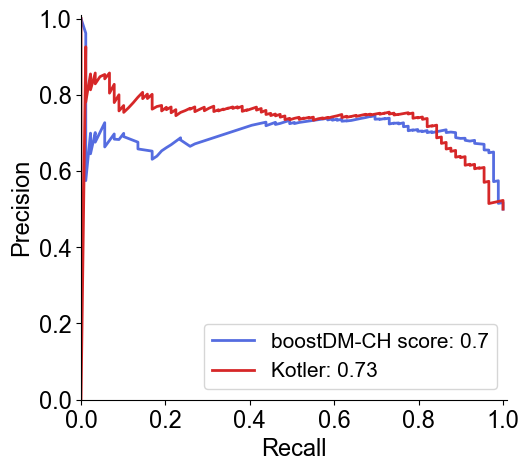

In [41]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(validation_set_predictions, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score, precision, recall, probs = plot_prc(validation_set_predictions, 'Kotler', ax=ax, color='#d62728', lw=2, alpha=1)
validation_set_predictions['prob_TP53'] = probs

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'Kotler: {auc_score:.2}'], fontsize=15, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [42]:
### Import rule-based deffinition of CH

import sys
sys.path.append("../../../Paper_data/Expert_curated_rules/")
from CH_harvard import niroula_CH
from CH_harvard import bick_CH
from CH_harvard import WHO_CH

### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['Set']==1) & (data[method]==1)])
    tn = len(data[(data['Set']==0) & (data[method]==0)])
    fp = len(data[(data['Set']==0) & (data[method]==1)])
    fn = len(data[(data['Set']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [43]:
validation_set_predictions[validation_set_predictions['prob_TP53']>=0.5]['Kotler'].min()

-0.929193211

In [44]:
validation_set_predictions[validation_set_predictions['prob_TP53']<0.5]['Kotler'].max()

-0.963599056

In [45]:
validation_set_predictions['cat_Kotler'] = validation_set_predictions['prob_TP53'].apply(lambda x:1 if x >=0.5 else 0)
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,Prot_pos,aachange_y,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,iteration,Kotler,prob_TP53,cat_Kotler
0,TP53,17,7674944,C,G,R196P,1,196,R196P,1,0,0,0,0.981253,1,1.0,1.0,1.0,1.0,0,-0.137850,0.682604,1
1,TP53,17,7674250,C,A,C238F,1,238,C238F,1,0,0,0,0.993032,1,1.0,0.0,0.0,1.0,0,0.009300,0.712547,1
2,TP53,17,7675160,G,C,P151R,1,151,P151R,1,0,0,0,0.982967,1,1.0,1.0,1.0,1.0,0,-0.318906,0.643600,1
3,TP53,17,7674241,G,C,S241C,1,241,S241C,1,0,0,0,0.958831,1,1.0,1.0,1.0,1.0,0,-0.174443,0.674904,1
4,TP53,17,7675075,A,T,H179Q,1,179,H179Q,1,0,0,0,0.731931,1,1.0,1.0,1.0,1.0,0,-0.110594,0.688276,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,TP53,17,7673748,T,C,K291R,0,291,K291R,1,0,0,0,0.087820,0,1.0,0.0,0.0,0.0,49,-1.303482,0.411147,0
8896,TP53,17,7674862,A,G,P223P,0,223,P223P,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49,-3.210785,0.099748,0
8897,TP53,17,7675114,T,C,S166S,0,166,S166S,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49,-2.922525,0.127658,0
8898,TP53,17,7674878,A,C,V218G,0,218,V218G,1,0,0,0,0.016132,0,1.0,0.0,0.0,1.0,49,-0.059821,0.698692,1


In [46]:
#Analysis

eval_boostdm = []
eval_experimental = []

#make same random
for i in range(0,50):
    gene_crossval_harv_i = validation_set_predictions[validation_set_predictions['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['Set']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['Set']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    
    ## Calculate all statistics for each method
    for method in ['boostDM_class', 'cat_Kotler']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']: 
            # Calculate statistic
            statistics.append(quality_statistic(gene_crossval_harv_equal_i, method=method, statistic=statistic))
        if method == 'boostDM_class': eval_boostdm.append(statistics)
        elif method == 'cat_Kotler': eval_experimental.append(statistics)


In [47]:
### Create summary dataframe with means

results_dataframe_12 = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM': pd.DataFrame(eval_boostdm).mean(),
                'experimental': pd.DataFrame(eval_experimental).mean(),
                'BoostDM_Q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_Q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q1': pd.DataFrame(eval_experimental).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q3': pd.DataFrame(eval_experimental).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0]})
results_dataframe_12

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,$F_{50}$,0.721120,0.753315,0.699797,0.735608,0.742268,0.761099
1,F1,0.740341,0.773125,0.726316,0.750000,0.765957,0.778378
2,Accuracy,0.727640,0.762247,0.707865,0.741573,0.752809,0.769663
3,Precision,0.708952,0.740746,0.683168,0.726316,0.727273,0.750000
4,Recall,0.775281,0.808989,0.775281,0.775281,0.808989,0.808989
5,NPV,0.751055,0.788911,0.740260,0.759036,0.784810,0.792683


In [48]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],0:3].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)

error_data

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,$F_{50}$,0.721120,0.753315,0.699797,0.735608,0.742268,0.761099
1,Precision,0.708952,0.740746,0.683168,0.726316,0.727273,0.750000
2,Recall,0.775281,0.808989,0.775281,0.775281,0.808989,0.808989


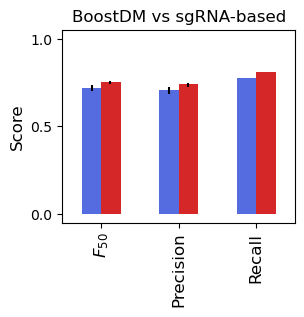

In [49]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic', figsize=(3,2.5), color=['#556CE0', '#d62728'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[abs(row.BoostDM-row.BoostDM_Q1)], [abs(row.BoostDM_Q3-row.BoostDM)]]
    plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[abs(row.experimental-row.experimental_Q1)], [(row.experimental_Q3-row.experimental)]]
    plt.errorbar(idx+0.12,row.experimental, yerr=ci, fmt=' ', ecolor = 'k')

plt.title('BoostDM vs sgRNA-based', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()